In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf

from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
url_train = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
url_test = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

urllib.request.urlretrieve(url_train, filename="ratings_train.txt")
urllib.request.urlretrieve(url_test, filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f2f89209340>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
import pandas as pd
import urllib.request

# Concatenate the dataframes
all_data = pd.concat([train_data, test_data], axis=0)

# Print the shape of the concatenated dataframe
print(all_data.shape)


(200000, 3)


In [7]:
print('리뷰 개수 :',len(all_data)) # 리뷰 개수 출력

리뷰 개수 : 200000


In [8]:
all_data[0:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
origin_len = len(all_data)

In [10]:
all_data.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [11]:
all_data = all_data.dropna(how='any')

In [12]:
print('결측치 제거 후 데이터 개수 :', len(all_data))  

결측치 제거 후 데이터 개수 : 199992


In [13]:
cleaned_corpus = all_data.drop_duplicates(['document'])   

In [14]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [15]:
cleaned_corpus.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [16]:
reviews = cleaned_corpus ['document']

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


/tmp/ipykernel_32/926328797.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


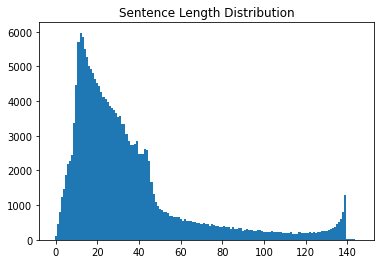

In [17]:
min_len = 999
max_len = 0
sum_len = 0

for sen in reviews:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(reviews))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in reviews:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [18]:
def check_sentence_with_length(reviews, length):
    count = 0
    
    for sen in reviews:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(reviews, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [19]:
check_sentence_with_length(reviews, 11)

백봉기 언제나오나요?
아주 모자라진 않다.
공유 존잘!!!ㅎㅎㅎ
4대2라니....최악
내 생의 최고의 영화
이딴게 한국 영화라니
번지수 잃고 갈팡질팡
너무나 감동적인 영화
내 인생 최고의 영화
참 재밌는 영화 ㅎㅎ
2.2고고하자 ㅋㅋㅋ
난 별로던데 -_ -
커스틴 때문에 좋겠다
재미있게봄 감동적이고
딱 90년대코미디영화
이건좀 아니잖아...
최고의 드라마....
야경꾼보다 엉망지루함
딱말해준다잉 안나온다
장선우 여전히 쓰레기
한국영화흥행의 시작점
이런게 영화라는거죠.
억지...억지....
세련되고 재밌었어요.
시대착오적 애니메이션
이건 또 뭔가요;;;
망작 중의 망작...
노답이다 진짜....
무의미한 애니메이션.
거 참 재밌는 영화균
상영관좀 늘려주세요.
픽션이지만 재미뚬ㅎㅎ
한지민은 여신이다..
또 번개냐 ㅋㅋㅋㅋㅋ
뷰우우우우티이이이이풀
막장드라됨급도 안됨.
2탄에 비하면 뭐..
개꿀잼ㅋ개꿀잼ㅋ10자
재밌어요 나름 괜찮음
너무 감동적이에욧><
그지같다고!!!!!!
별로에요 재미없네요호
짜리몽땅 파이팅!!!
구관이 명관이다...
진짜볼만함!!@!@!
하 시방ㅡㅡ:@!?.
이제보니까 장백기였네
쓰레기..10자 채움
하나님살려주시지...
대략 재미 없음...
굿굿 잘봤습니다~~ㅅ
나도 다큐나 찍어볼까
마지막에어이없네왜죽어
아바타같은소리하네..
이건 정말 명작이네요
별덤높이기다디다디도러
재밌다........
쓰레기다 솔직히...
정말 현실성없는 영화
재밌게 잘봣습니다!!
어린아이들만 재미있고
그렇게 대단하지 않다
로코좋아하는분께추천!
린제리 로한 사랑함.
내용을말로표현못하게씀
잼있습니다 야호호호호
정말 훈훈한방송입니다
박준형?이 나온다;;
병만옹 짱짜아악앙맨앤
재미있네요.훌륭합니다
정말 소름끼친다!!!
오겡끼데쓰까 부시맨!
좋다.,/,./,./
말할것도없다 최고ㅇㅇ
일하기싫었나봐여ㅎㅅㅎ
인생을 느끼다....
기억이 가물가물하네요
꿀잼 다시보고싶은영화
표절?표절?표절?표절
이거 우리나라꺼 아님
개연성은 개나 줘버려
엉망진창 로맨틱드라마
가슴이 바운OO운스~
노잼 ㅡ

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


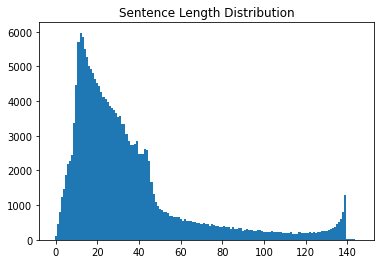

In [20]:
# 노이즈 제거 후 다시 실행해보기

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(reviews))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

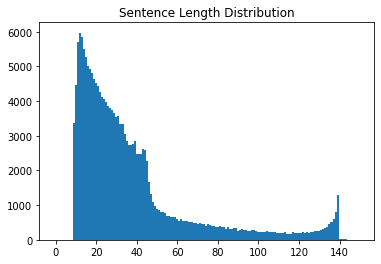

In [21]:
# 편향성 없애기 위해 150 이상 없애고 10미만 없앰

max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<AxesSubplot:>

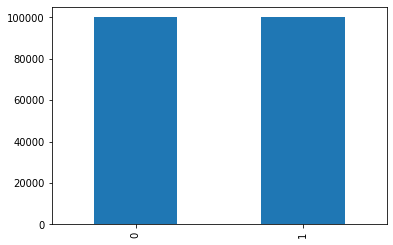

In [22]:
# 전체적인 긍부정 유무를 따져보자

all_data ['label'].value_counts().plot(kind = 'bar')

In [23]:
# tokenizer 함수

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [24]:
# 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []  # 토큰화된 데이터 저장 리스트 공간

for kor in filtered_corpus:
    split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [25]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 444122


In [26]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 영화
1 : 너무
2 : 정말
3 : 진짜
4 : 이
5 : 영화.
6 : 더
7 : 왜
8 : 이런
9 : 그냥
10 : 수
11 : 영화를


In [27]:
# SentencePiece

In [28]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 374785 Feb 22 09:42 korean_spm.model
-rw-r--r-- 1 root root 144131 Feb 22 09:42 korean_spm.vocab


In [29]:
def performance (model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [30]:
# unigram
performance(model='korean_spm.model')

[1391, 10, 381, 15, 1305, 10, 129, 18, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [31]:
# bpe 
performance(model='kor_spm_bpe_8k.model')

[4809, 870, 6550, 6298, 6317, 1373, 6395, 6288, 6286]
['▁아버', '지가', '방', '에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [32]:
# Tokenizer 함수 작성

In [33]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [34]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
# s.Load('kor_spm_bpe_16k.model')  # lstm 학습시 오류

s.Load('korean_spm.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm')           
print(tensor)
# print(word_index)
# print(index_word)

[[ 584 2733   14 1192 2016    4    0    0    0    0]
 [1538 2442  317  579   10    3   16 7947  652    8]]


In [35]:
# LSTM
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import urllib.request
import sentencepiece as spm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [36]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [37]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
# s.Load('kor_spm_bpe_16k.model')  # lstm 학습시 오류

s.Load('korean_spm.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm')           
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  584 2733   14 1192 2016    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0

In [38]:
tensor, word_index, index_word = sp_tokenize(s, all_data['document'], 'korean_spm')

In [39]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(all_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [40]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

127994 31999 39999
127994 31999 39999


In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128)) 
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [42]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)


In [43]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/10
2000/2000 [==============================] - 44s 10ms/step - loss: 0.4036 - accuracy: 0.8190 - val_loss: 0.3454 - val_accuracy: 0.8517
Epoch 2/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.3139 - accuracy: 0.8651 - val_loss: 0.3242 - val_accuracy: 0.8579
Epoch 3/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.2799 - accuracy: 0.8812 - val_loss: 0.3274 - val_accuracy: 0.8561
Epoch 4/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.2525 - accuracy: 0.8948 - val_loss: 0.3324 - val_accuracy: 0.8604
Epoch 5/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.2264 - accuracy: 0.9065 - val_loss: 0.3477 - val_accuracy: 0.8562
Epoch 6/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.2017 - accuracy: 0.9177 - val_loss: 0.3678 - val_accuracy: 0.8537
Epoch 00006: early stopping


In [44]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

1000/1000 - 4s - loss: 0.3589 - accuracy: 0.8558
[0.3588990569114685, 0.8558080196380615]
